In [1]:
devtools::install_github("clairbarnes/rwwa")
library(rwwa)

Skipping install of 'rwwa' from a github remote, the SHA1 (689ddfe1) has not changed since last install.
  Use `force = TRUE` to force installation

Loading required package: extRemes

Loading required package: Lmoments

Loading required package: distillery


Attaching package: ‘extRemes’


The following objects are masked from ‘package:stats’:

    qqnorm, qqplot




# Model exploration

## Parametric form

In [2]:
# load data
df <- merge(merge(load_ts("ts/panama_pr-wetseason_chirps.dat", col.names = c("year", "chirps")),
                  load_ts("ts/panama_pr-wetseason_mswep.dat", col.names = c("year", "mswep"))),
                  load_ts("ts/panama_pr-wetseason_acp-sp.dat", col.names = c("year", "acp")), all = T)

df <- merge(df, setNames(df[df$year >= 1979, c("year", "acp")], c("year", "acp_sat")), all = T)

In [5]:
# normal distribution is not a bad fit
apply(df[,-1], 2, function(x) c("skewness" = moments::skewness(x, na.rm = T), "kurtosis" = moments::kurtosis(x, na.rm = T)-3, "ks.pval" = ks.test(scale(x), pnorm)$p.value))

,chirps,mswep,acp,acp_sat
skewness,0.2507408,0.03800706,0.4169208,0.3453182
kurtosis,-0.1182673,-0.13779223,0.4859299,1.1132165
ks.pval,0.9949046,0.97490654,0.6350088,0.7634679


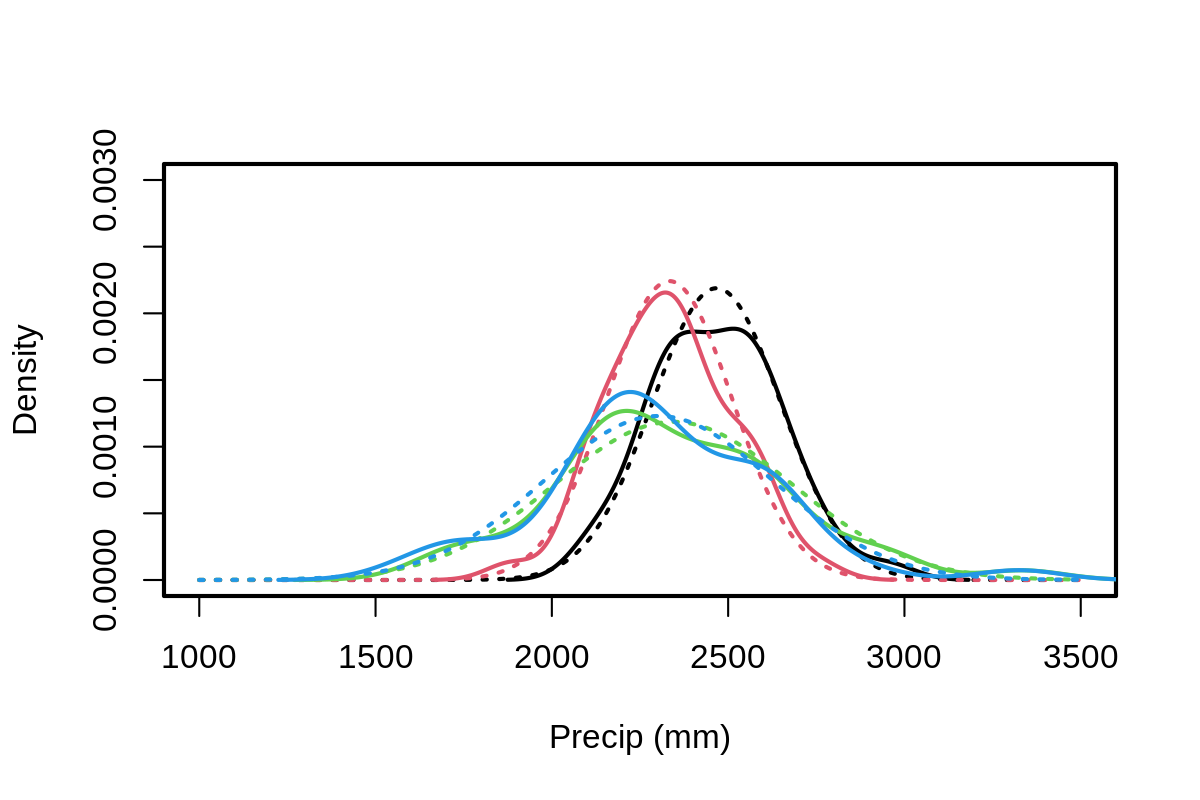

In [6]:
prep_window(c(1,1), h = 4, w = 6, lwd = 2)
x <- 1000:3500

plot(1, type = "n", xlim = range(x), ylim = c(0,0.003), xlab = "Precip (mm)", ylab = "Density")
for(i in 1:4) {
    lines(density(df[,i+1], na.rm = T), col = i)
    lines(x, dnorm(x, mean(df[,i+1], na.rm = T), sd(df[,i+1], na.rm = T)), lty = 3, col = i)
}

## Fit models

In [14]:
# load & compile data
nino <- load_ts("ts/panama_nino-rs.dat", col.names = c("year", "nino"))
gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2023]

df_chirps <- merge(merge(gmst, nino), load_ts("ts/panama_pr-wetseason_chirps.dat", col.names = c("year", "pr")))
df_mswep <- merge(merge(gmst, nino), load_ts("ts/panama_pr-wetseason_mswep.dat", col.names = c("year", "pr")))
df_acp_sp <- merge(merge(gmst, nino), load_ts("ts/panama_pr-wetseason_acp-sp.dat", col.names = c("year", "pr")))
df_acp_long <- merge(merge(gmst, nino), load_ts("ts/panama_pr-wetseason_acp-long.dat", col.names = c("year", "pr")))
df_acp_mid <- merge(merge(gmst, nino), load_ts("ts/panama_pr-wetseason_acp-mid.dat", col.names = c("year", "pr")))
df_acp_sat <- merge(merge(gmst, nino), load_ts("ts/panama_pr-wetseason_acp-sat.dat", col.names = c("year", "pr")))

cov_2023 <- data.frame(gmst = gmst$gmst[gmst$year == 2023], nino = nino$nino[nino$year == 2023])
cov_cf <- rbind("hist" = cov_2023 - c(1.2, 0), "neut" = c(cov_2023$gmst, 0))

### Mixture model formulation
The density of the long time series looks a lot like a mixture model - would it be better to treat Nino/Nina as factor variable?

In [125]:
df <- df_acp_long
df$nino_type <- as.factor(c(2,1,3)[findInterval(df$nino, c(-Inf, -0.7, 0.7, Inf))] )

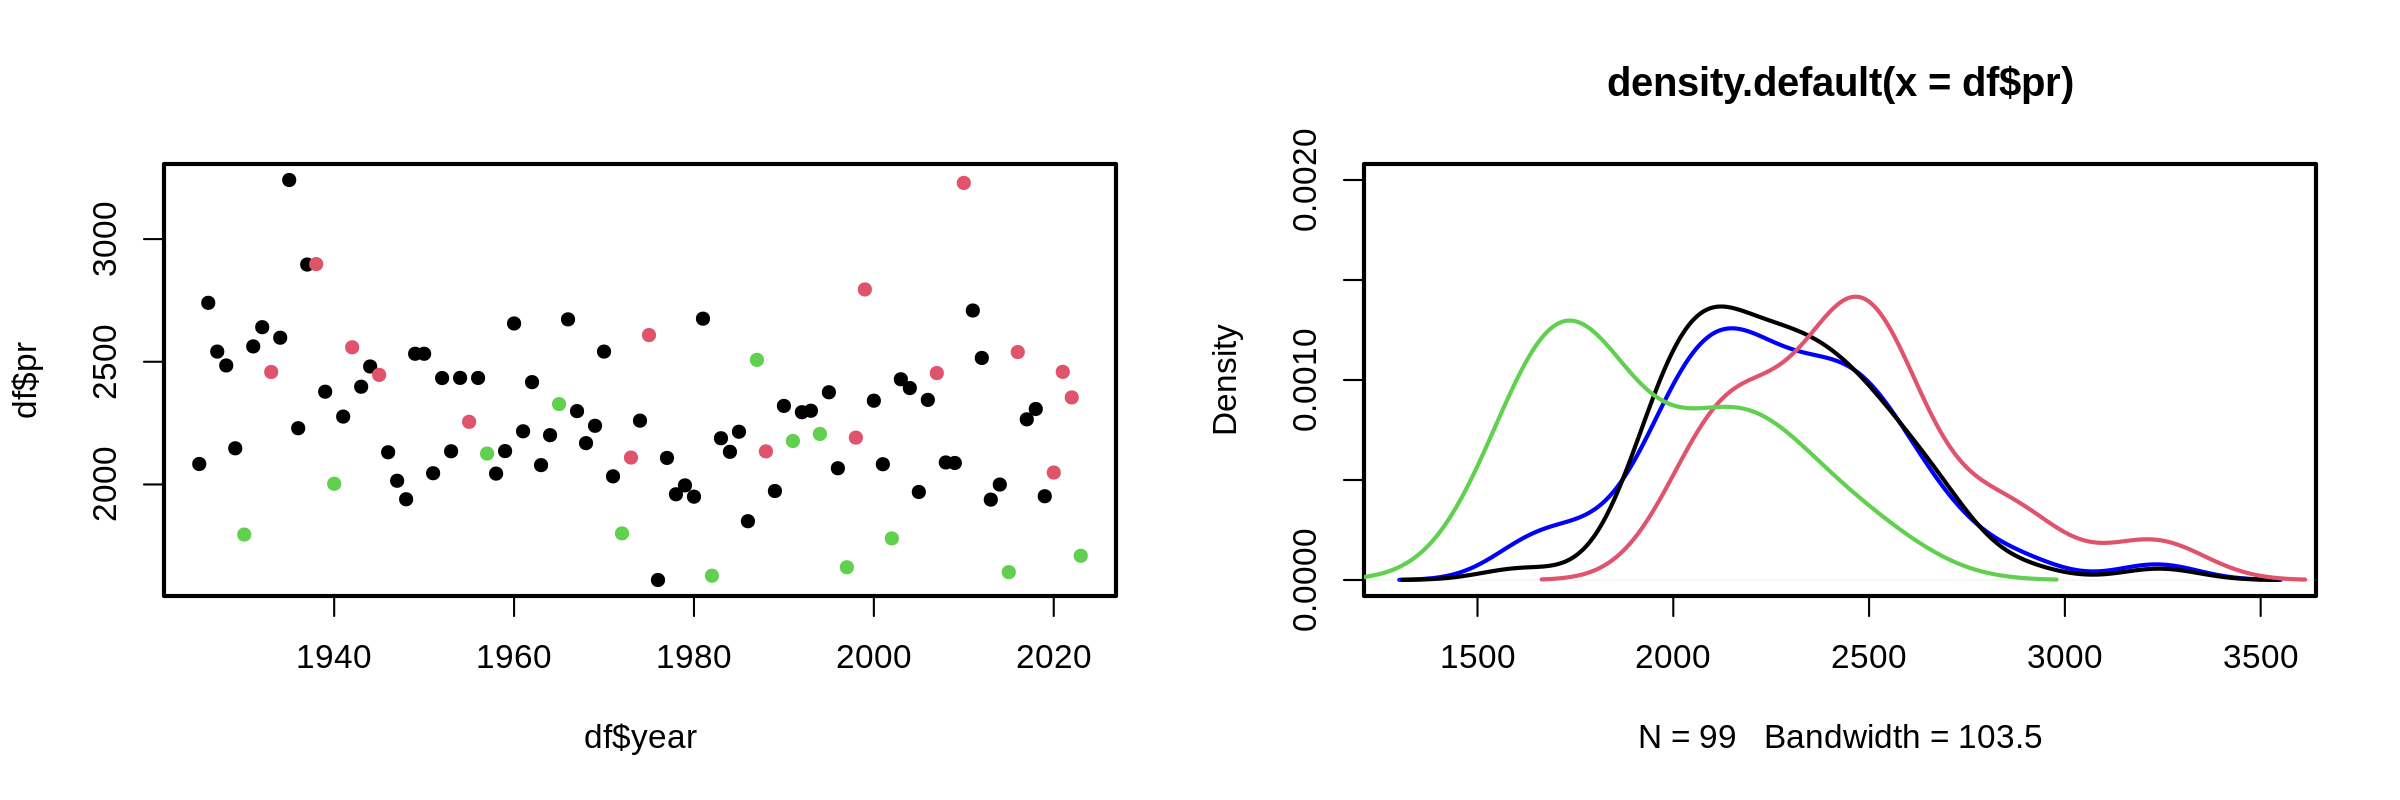

In [128]:
prep_window(c(1,2), h = 4, w = 6, lwd = 2)

plot(df$year, df$pr, col = df$nino_type, pch = 20)

plot(density(df$pr), col = "blue", lwd = 2, ylim = c(0,0.002))
for(i in 1:3) lines(density(df$pr[df$nino_type == i]), col = i)

In [110]:
lm_factor <- lm(pr ~ gmst + nino_type, df)
lm_cts <- lm(pr ~ gmst + nino, df)

lmtest::coxtest(lm_factor, lm_cts)

,Estimate,Std. Error,z value,Pr(>|z|)
,<dbl>,<dbl>,<dbl>,<dbl>
fitted(M1) ~ M2,-5.680844,2.162620,-2.6268338,0.008618342
fitted(M2) ~ M1,-2.088203,2.339465,-0.8925984,0.372072262


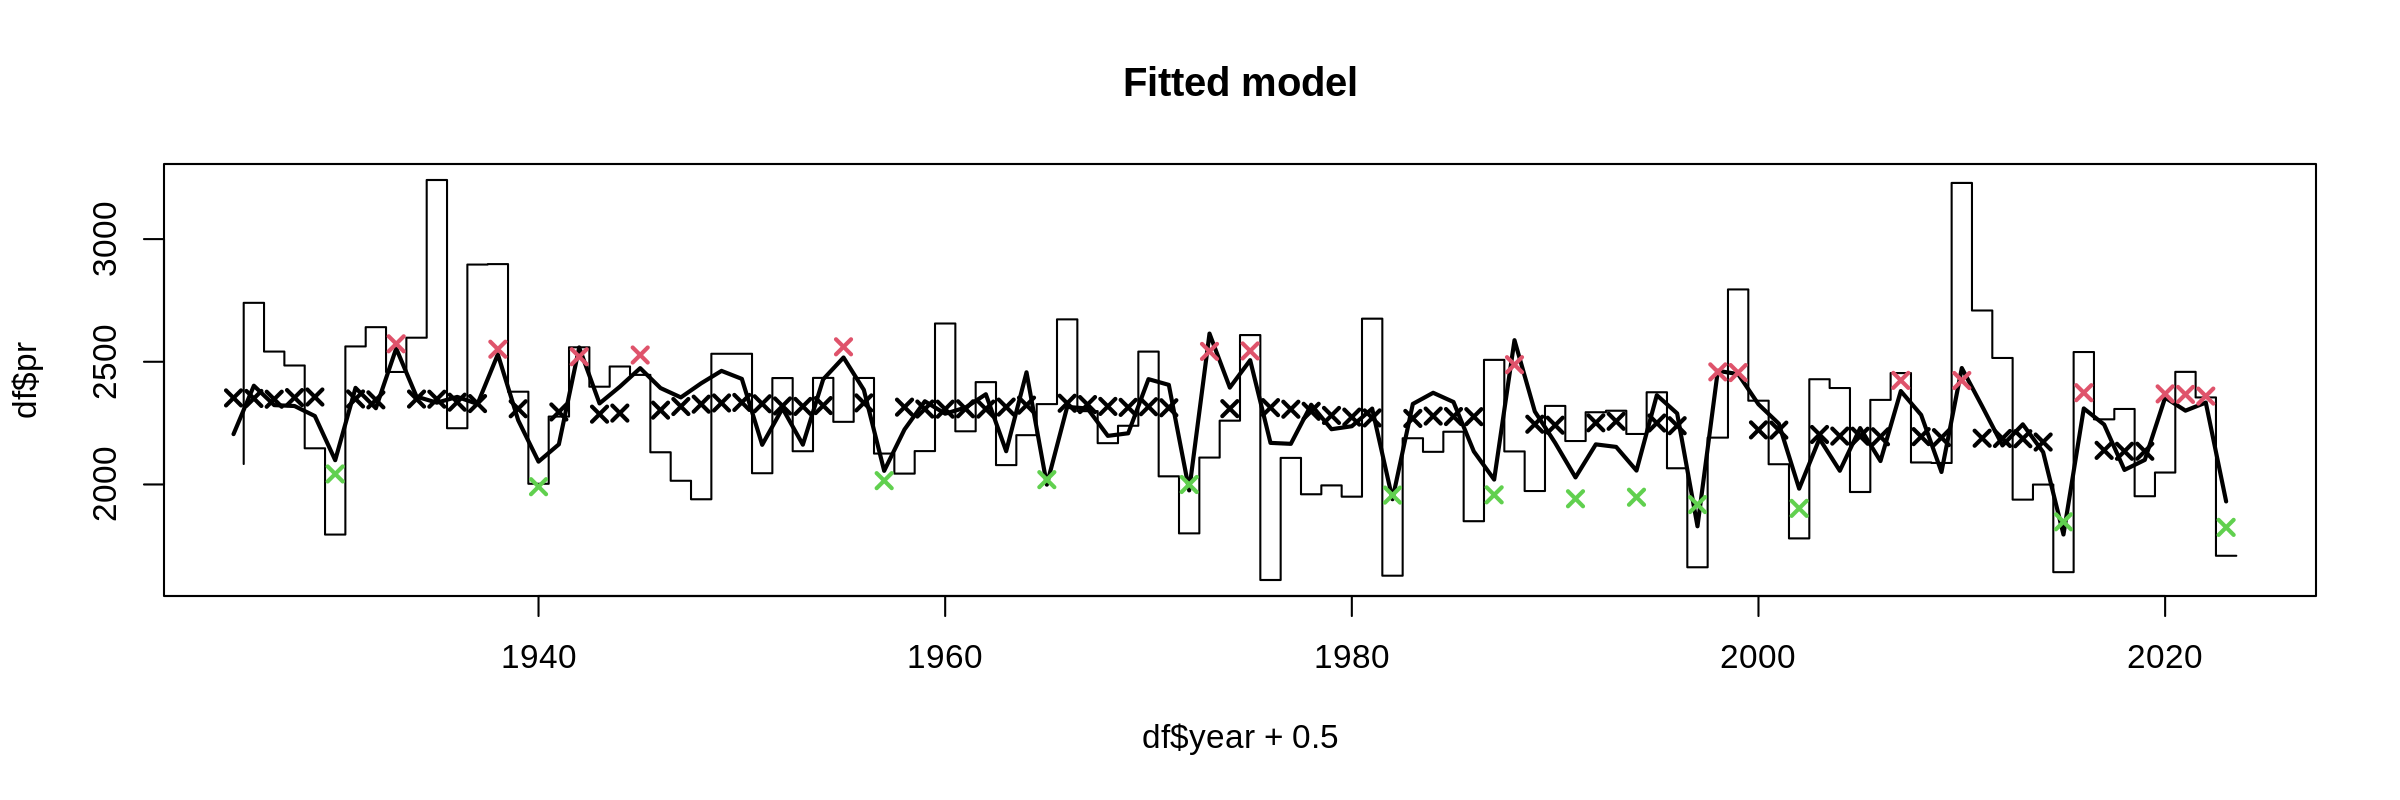

In [146]:
plot(df$year+0.5, df$pr, type = "S", main = "Fitted model")
lines(df$year, fitted(lm_cts), lwd = 2)
points(df$year, fitted(lm_factor), pch = 4, lwd = 2, col = df$nino_type)


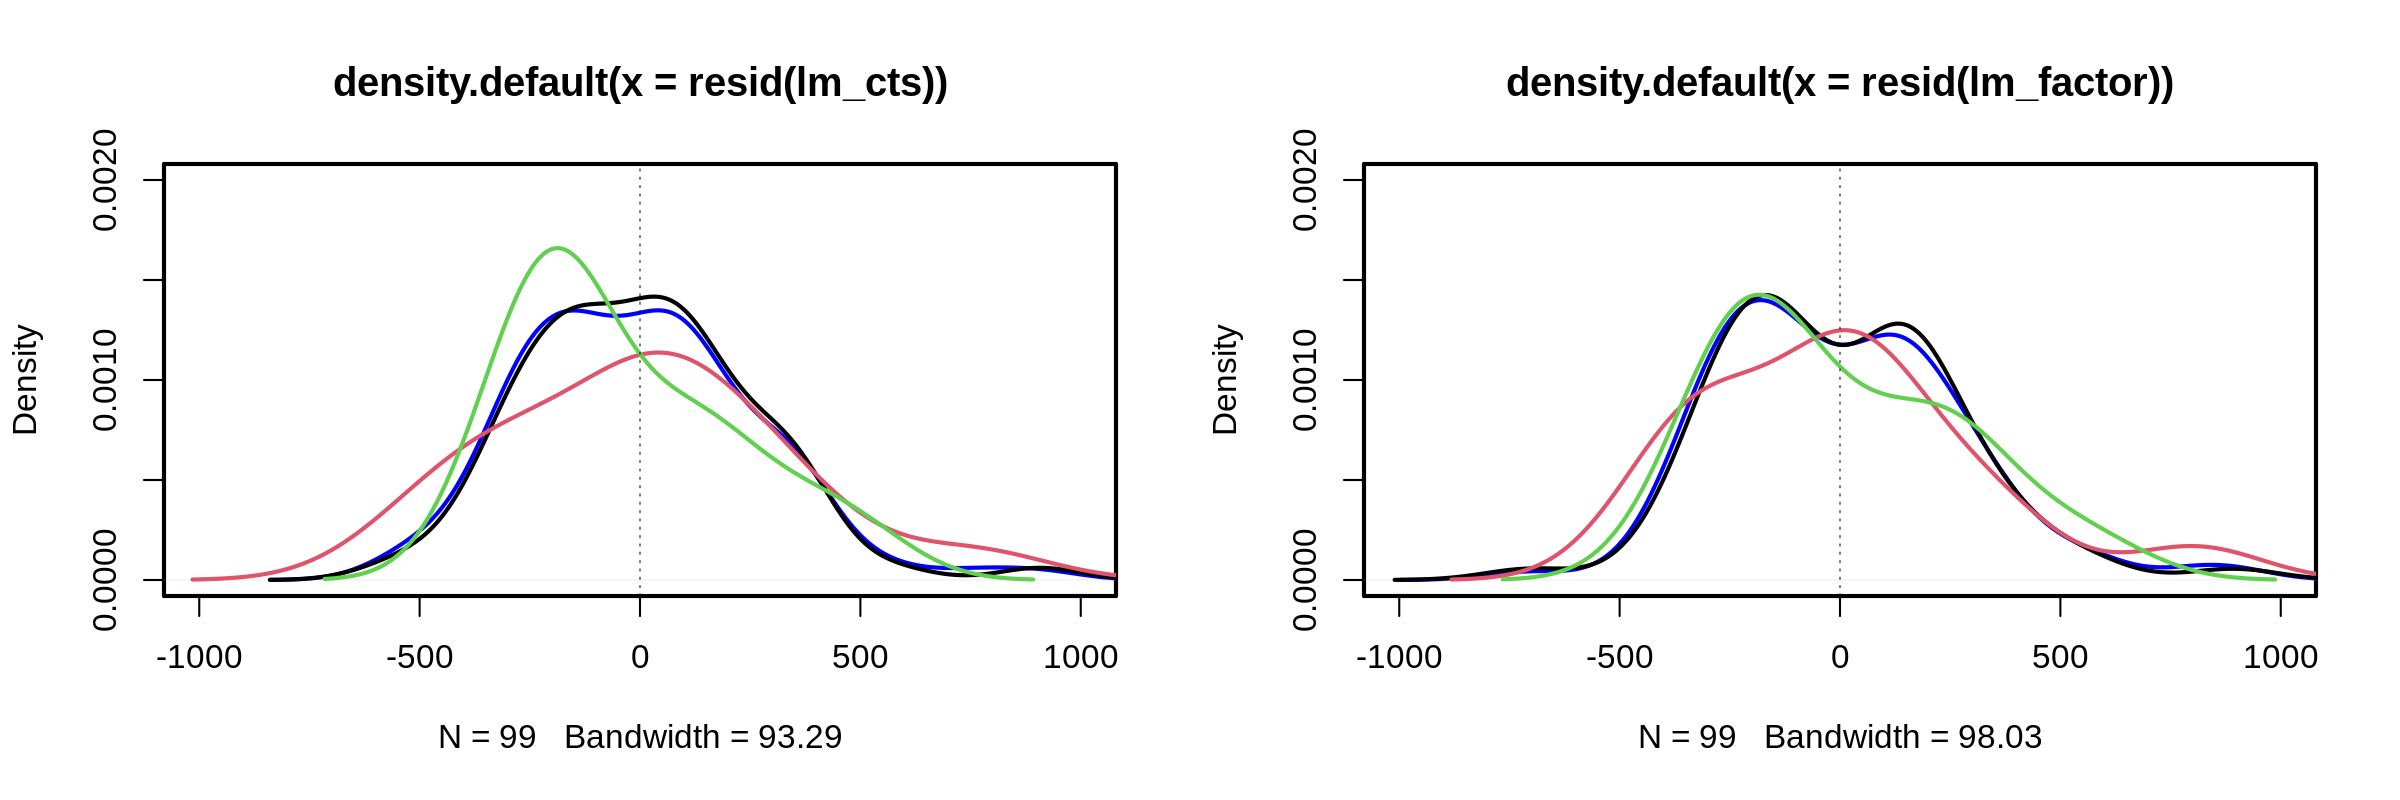

In [147]:
prep_window(c(1,2), h = 4, w = 6, lwd = 2)

plot(density(resid(lm_cts)), col = "blue", ylim = c(0,0.002), xlim = c(-1000,1000))
for(i in 1:3) lines(density(resid(lm_cts)[df$nino_type == i]), col = i)
abline(v = 0, lwd = 0.5, lty = 3)

plot(density(resid(lm_factor)), col = "blue", ylim = c(0,0.002), xlim = c(-1000,1000))
for(i in 1:3) lines(density(resid(lm_factor)[df$nino_type == i]), col = i)
abline(v = 0, lwd = 0.5, lty = 3)

### Linear model formulation

In [15]:
models <- list("CHIRPS" = fit_ns("norm", "fixeddisp", df_chirps, "pr", c("gmst", "nino"), lower = T),
               "MSWEP" = fit_ns("norm", "fixeddisp", df_mswep, "pr", c("gmst", "nino"), lower = T),
               "ACP sat" = fit_ns("norm", "fixeddisp", df_acp_sat, "pr", c("gmst", "nino"), lower = T),
               "ACP mid" = fit_ns("norm", "fixeddisp", df_acp_mid, "pr", c("gmst", "nino"), lower = T),
               "ACP long" = fit_ns("norm", "fixeddisp", df_acp_long, "pr", c("gmst", "nino"), lower = T),
               "ACP all" = fit_ns("norm", "fixeddisp", df_acp_sp, "pr", c("gmst", "nino"), lower = T))

In [16]:
prep_window(c(1,2), h = 4, w = 6, lwd = 2)
plot_covtrend(models[["ACP long"]], "gmst", plot_cov = data.frame(gmst = df_acp_long$gmst, nino = mean(df_acp_long$nino)), 
              ci_cov = data.frame(gmst = gmst$gmst[gmst$year == 2023] + c(0,-1.2), nino = mean(df_acp_long$nino)), nsamp = 10)
plot_covtrend(models[["ACP long"]], "nino", plot_cov = data.frame(gmst = mean(df_acp_long$gmst), nino = (df_acp_long$nino)), 
              ci_cov = data.frame(gmst = mean(df_acp_long$gmst), nino = c(nino$nino[nino$year == 2023], 0)), nsamp = 10)
abline(v = 0, lty = 3)

## Check residuals

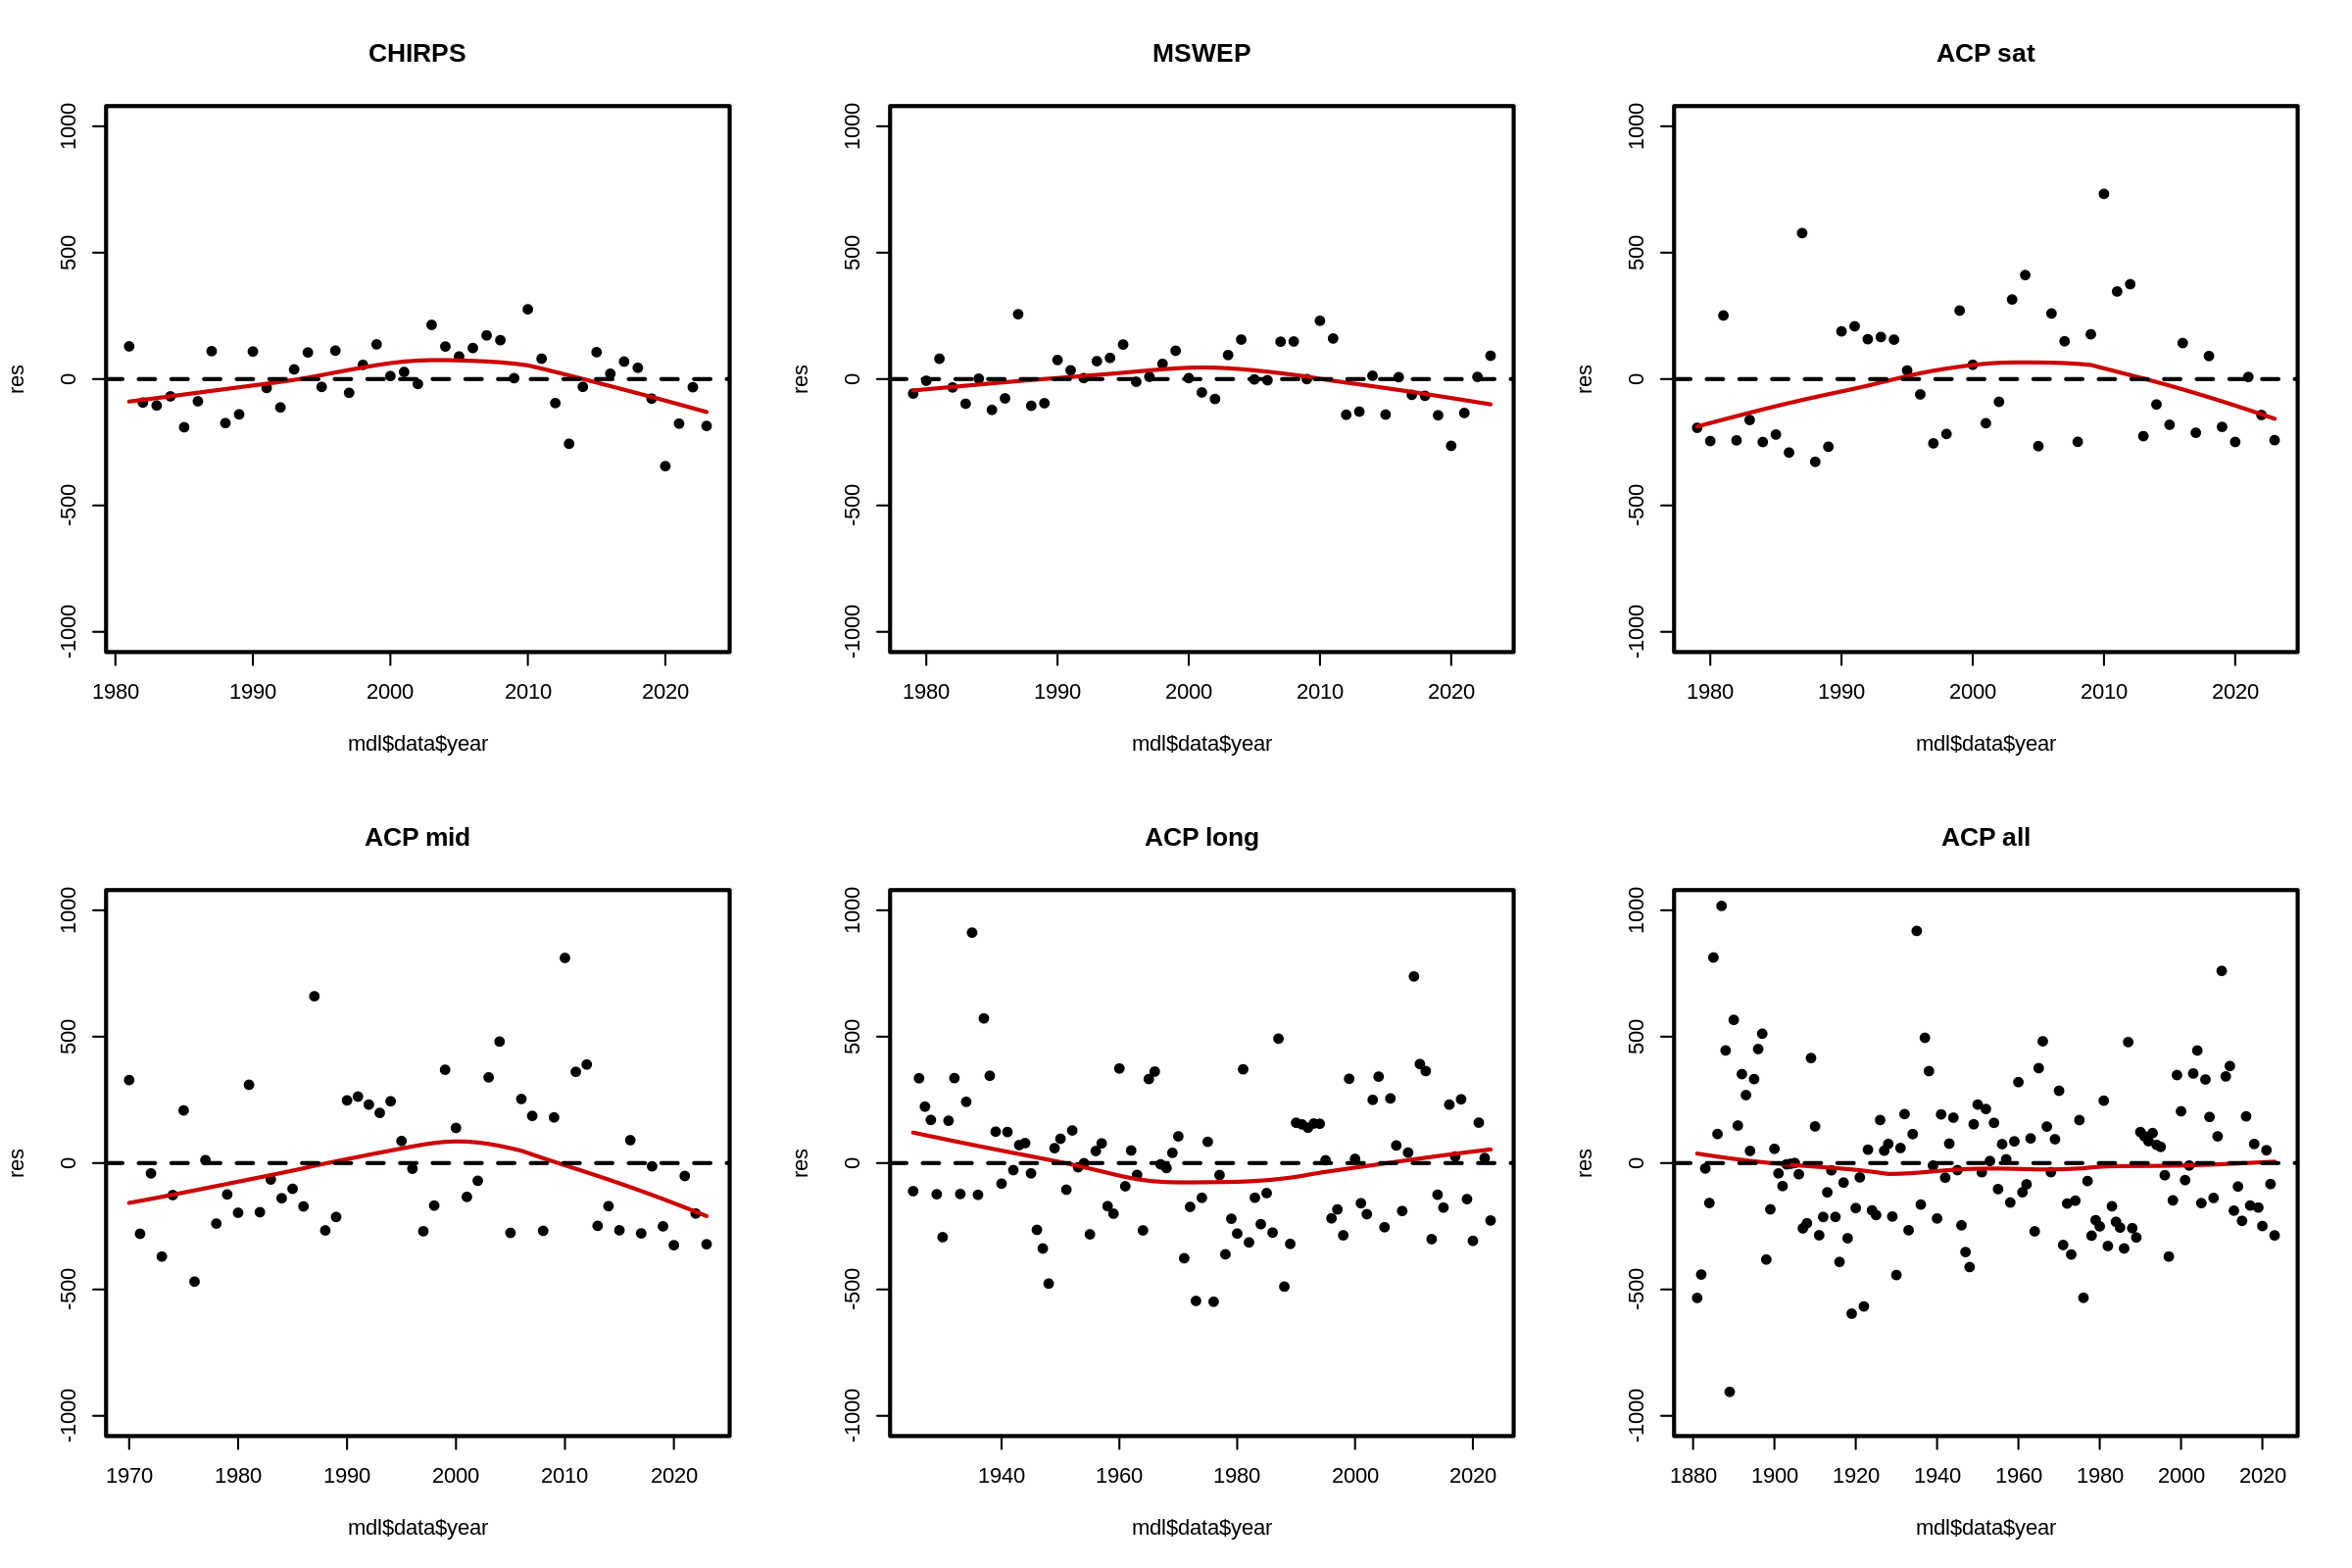

In [216]:
prep_window(c(2,3), h = 4, w = 4, lwd = 2)

for (i in 1:length(models)) {
    mdl <- models[[i]]
    res <- mdl$x - ns_pars(mdl)$loc
    plot(mdl$data$year, res, main = names(models)[i], ylim = c(-1000,1000))
    lines(lowess(mdl$data$year, res), col = "red3")
    abline(h = 0, lty = 2)
}

### Does PDO explain remaining systematic variability?

Warning message in readLines(file, n = thisblock):
“incomplete final line found on 'data/pdo_ersst.txt'”


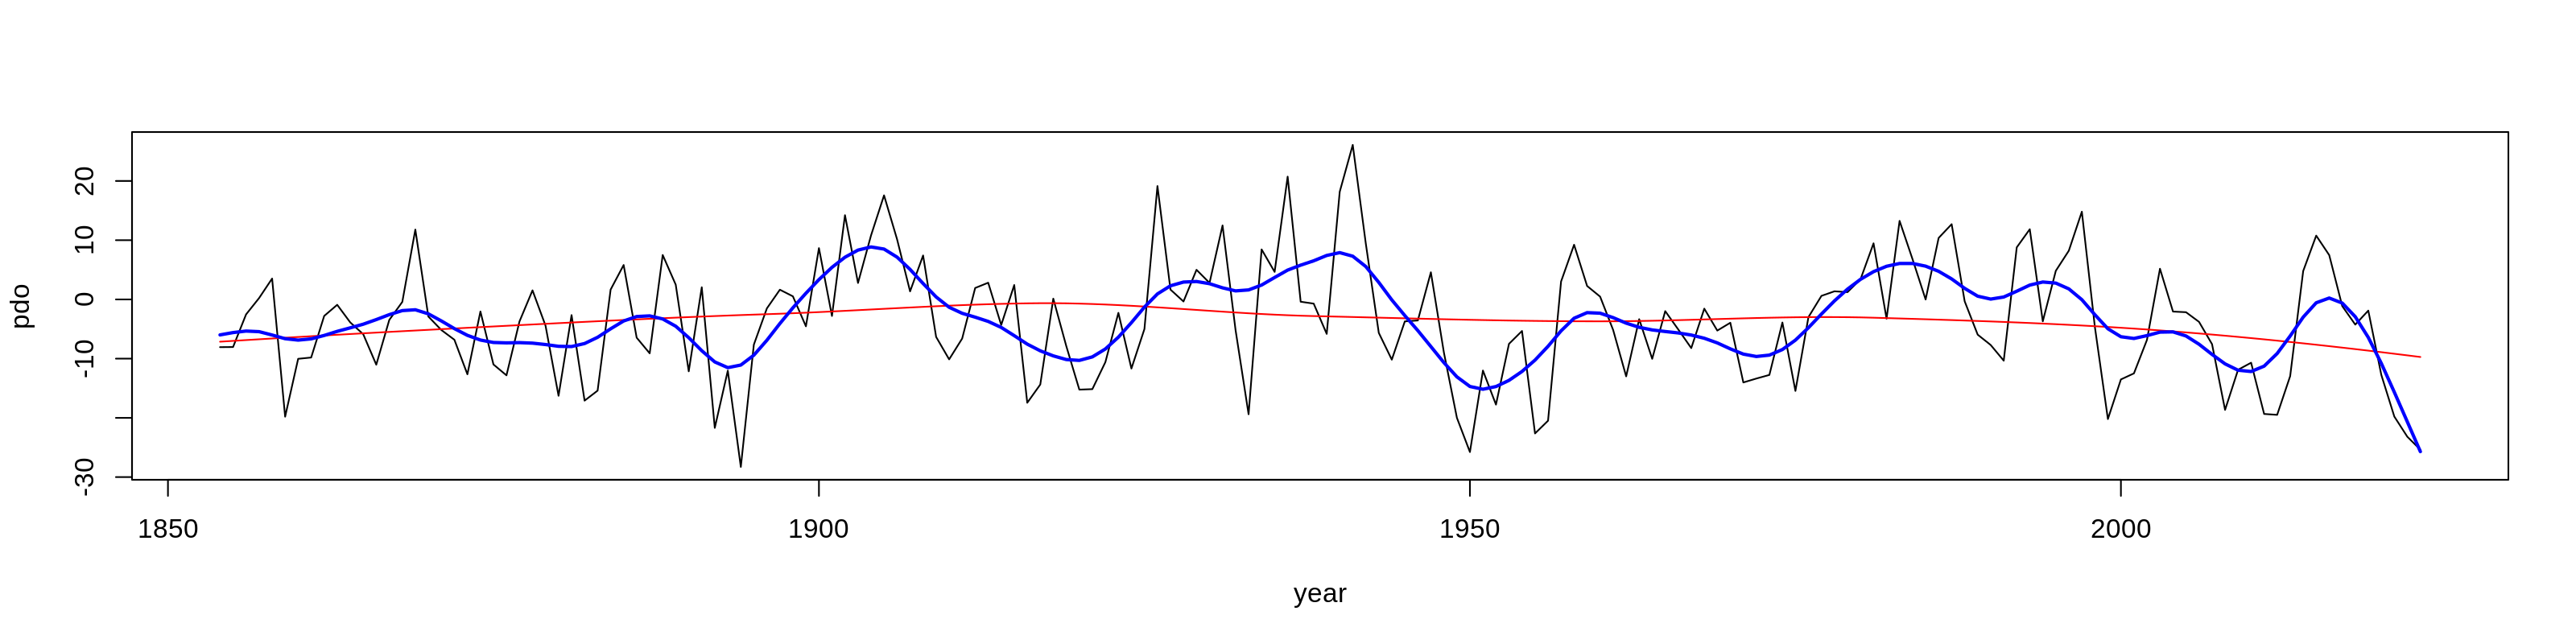

In [282]:
pdo <- rowSums(read.fwf("data/pdo_ersst.txt", skip = 2, widths = c(5, rep(6, 11)), row.names = "V1", na.strings = 99.99))
pdo <- data.frame(year = names(pdo), pdo = pdo)
pdo <- pdo[pdo$year < 2024,,drop = F]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
plot(pdo, type = "l")
lines(pdo$year, fitted(loess(pdo ~ year, pdo), degree = 1, span = 0.25), col = "red")

# add smoothed version as alternative covariate
pdo$pdo_sm <- fitted(smooth.spline(pdo$year, pdo$pdo, df = 30))
lines(pdo$year, pdo$pdo_sm, col = "blue", lwd = 2)

In [304]:
# load & compile data
nino <- load_ts("ts/panama_nino-rs.dat", col.names = c("year", "nino"))
gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2023]

df <- merge(merge(merge(gmst, nino), load_ts("ts/panama_pr-wetseason_acp-sat.dat", col.names = c("year", "pr"))), pdo)

cov_2023 <- df[df$year == 2023,c("gmst", "nino", "pdo", "pdo_sm")]
cov_cf <- rbind("hist" = cov_2023 - c(1.2,0,0,0), "neut" = cov_2023 - c(0,cov_2023$nino,0,0))

In [305]:
models <- list("gmst+nino" = fit_ns("norm", "fixeddisp", df, "pr", c("gmst", "nino"), lower = T),
               "gmst+pdo" = fit_ns("norm", "fixeddisp", df, "pr", c("gmst", "pdo"), lower = T),
               "gmst+nino+pdo" = fit_ns("norm", "fixeddisp", df, "pr", c("gmst", "nino", "pdo"), lower = T),
               "gmst+nino+pdo_sm" = fit_ns("norm", "fixeddisp", df, "pr", c("gmst", "nino", "pdo_sm"), lower = T))

In [306]:
# no evidence that fit is improved
round(sapply(models, aic), 2)

gmst+nino         gmst+pdo    gmst+nino+pdo gmst+nino+pdo_sm 
          635.30           653.59           637.30           637.83

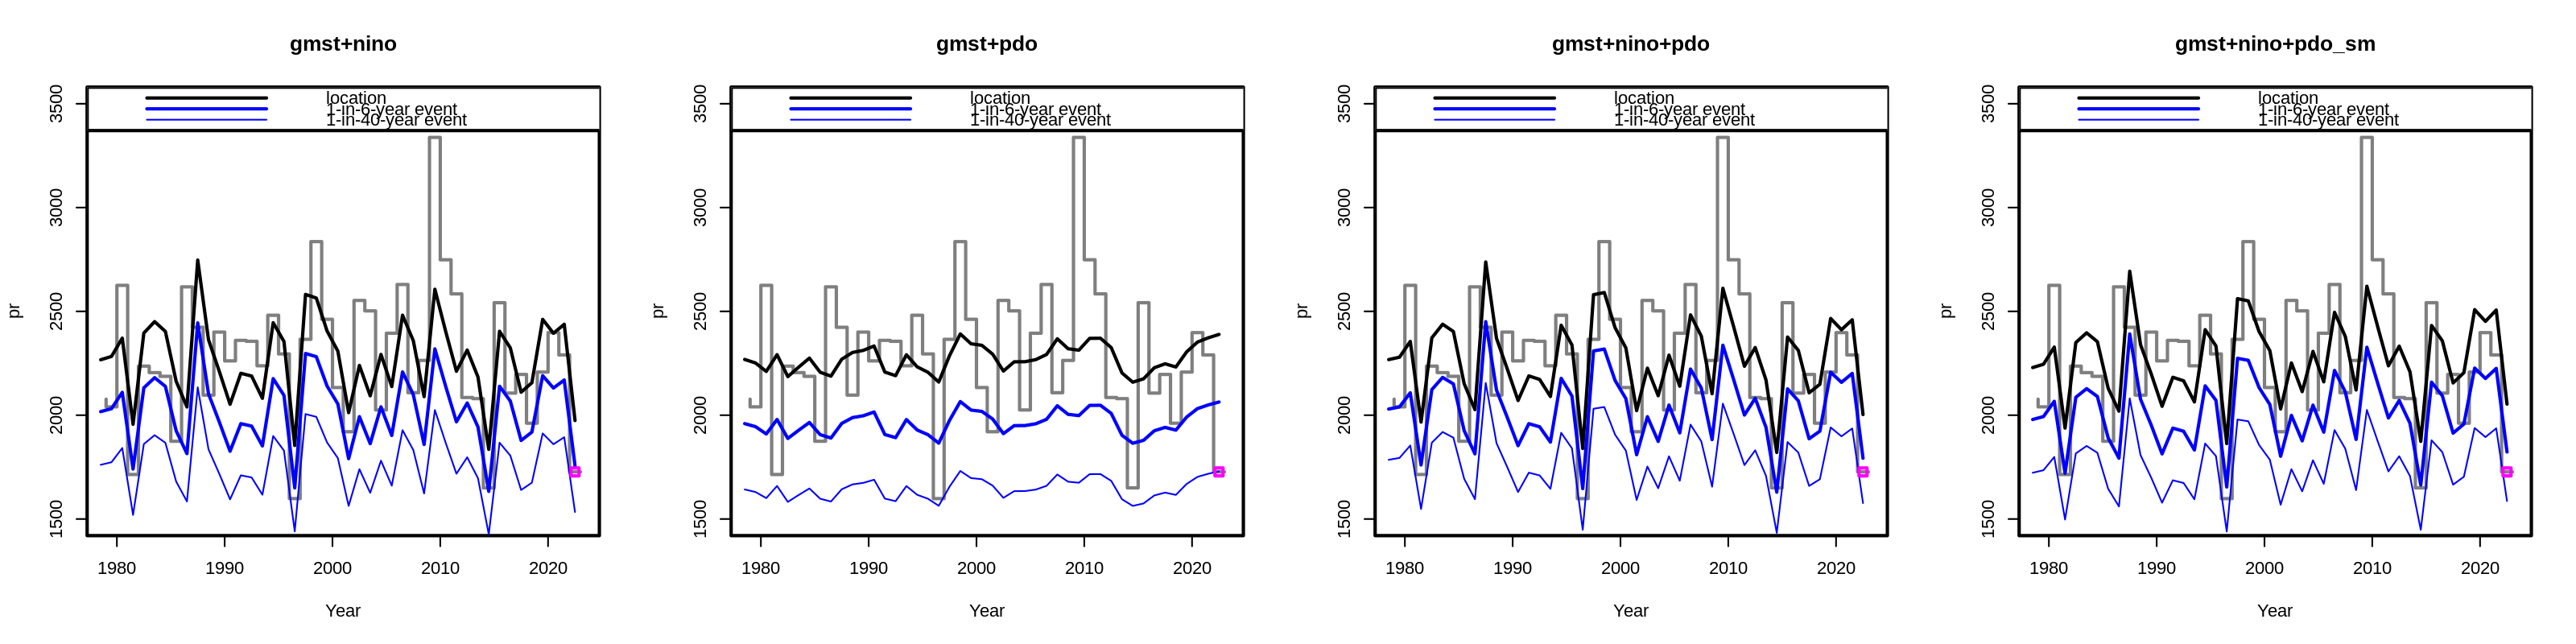

In [307]:
prep_window(c(1,4), h = 4, w = 4, lwd = 2)

for (i in 1:length(models)) {
    mdl <- models[[i]]
    plot_trend(mdl, main = names(models)[i])
}

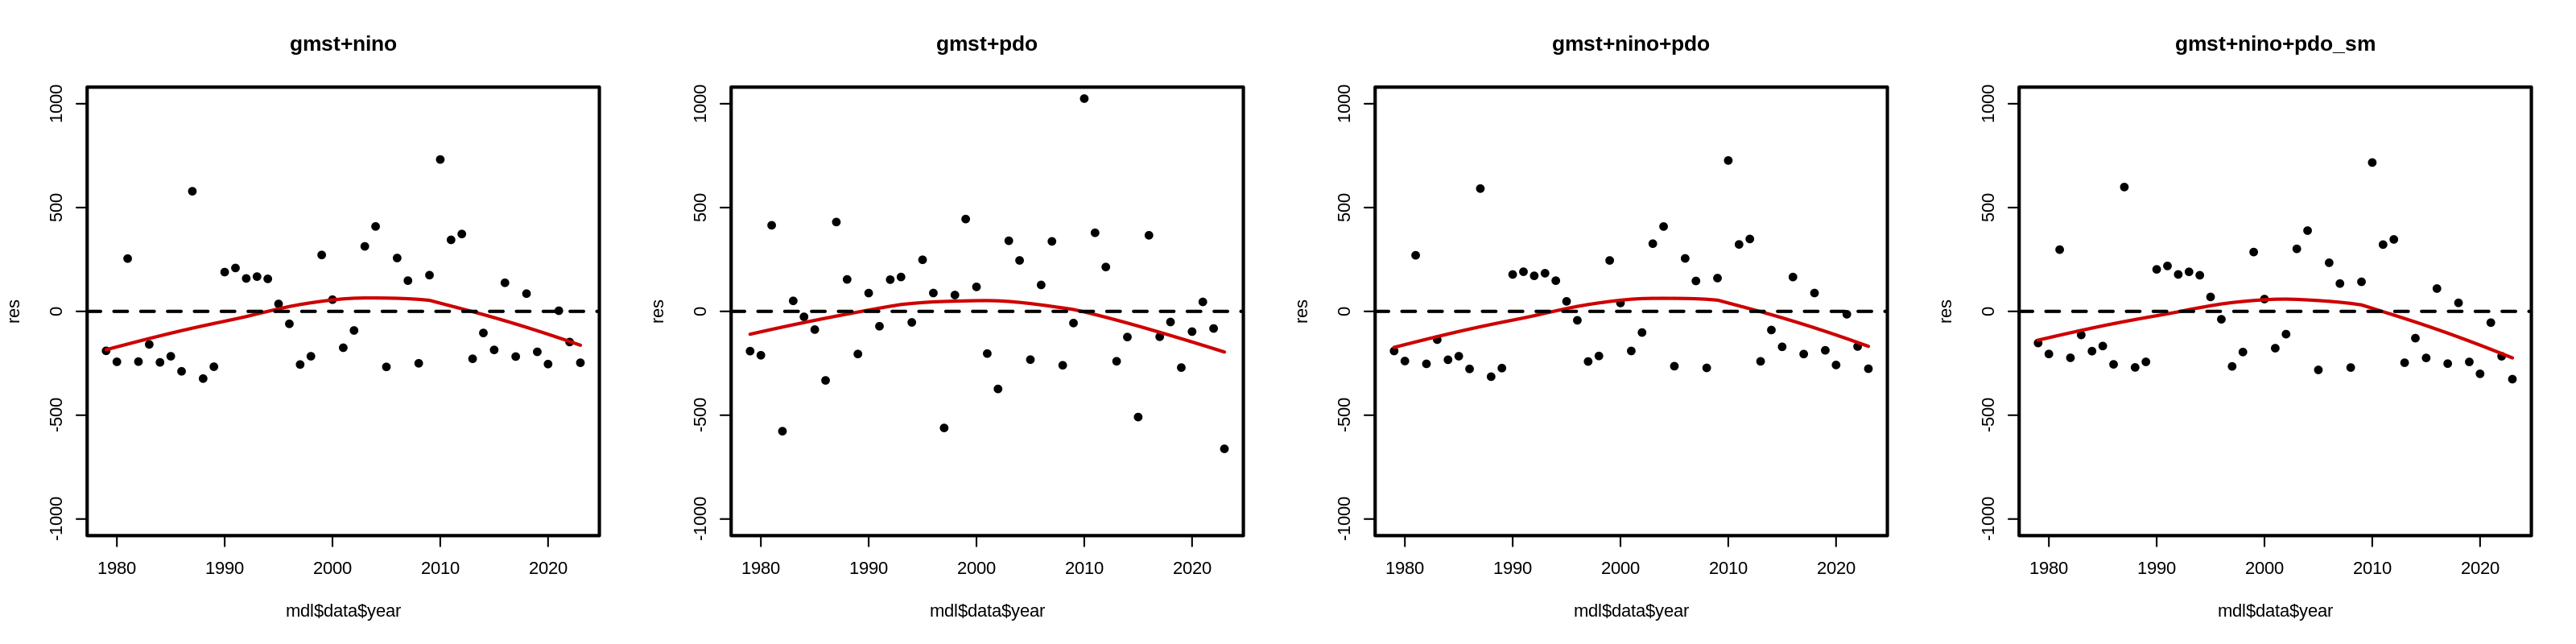

In [308]:
prep_window(c(1,4), h = 4, w = 4, lwd = 2)

for (i in 1:length(models)) {
    mdl <- models[[i]]
    res <- mdl$x - ns_pars(mdl)$loc
    plot(mdl$data$year, res, main = names(models)[i], ylim = c(-1000,1000))
    lines(lowess(mdl$data$year, res), col = "red3")
    abline(h = 0, lty = 2)
}

In [310]:
all_res <- sapply(models, function(mdl) boot_ci(mdl, cov_f = cov_2023, cov_cf = cov_cf, nsamp = 100), simplify = F)

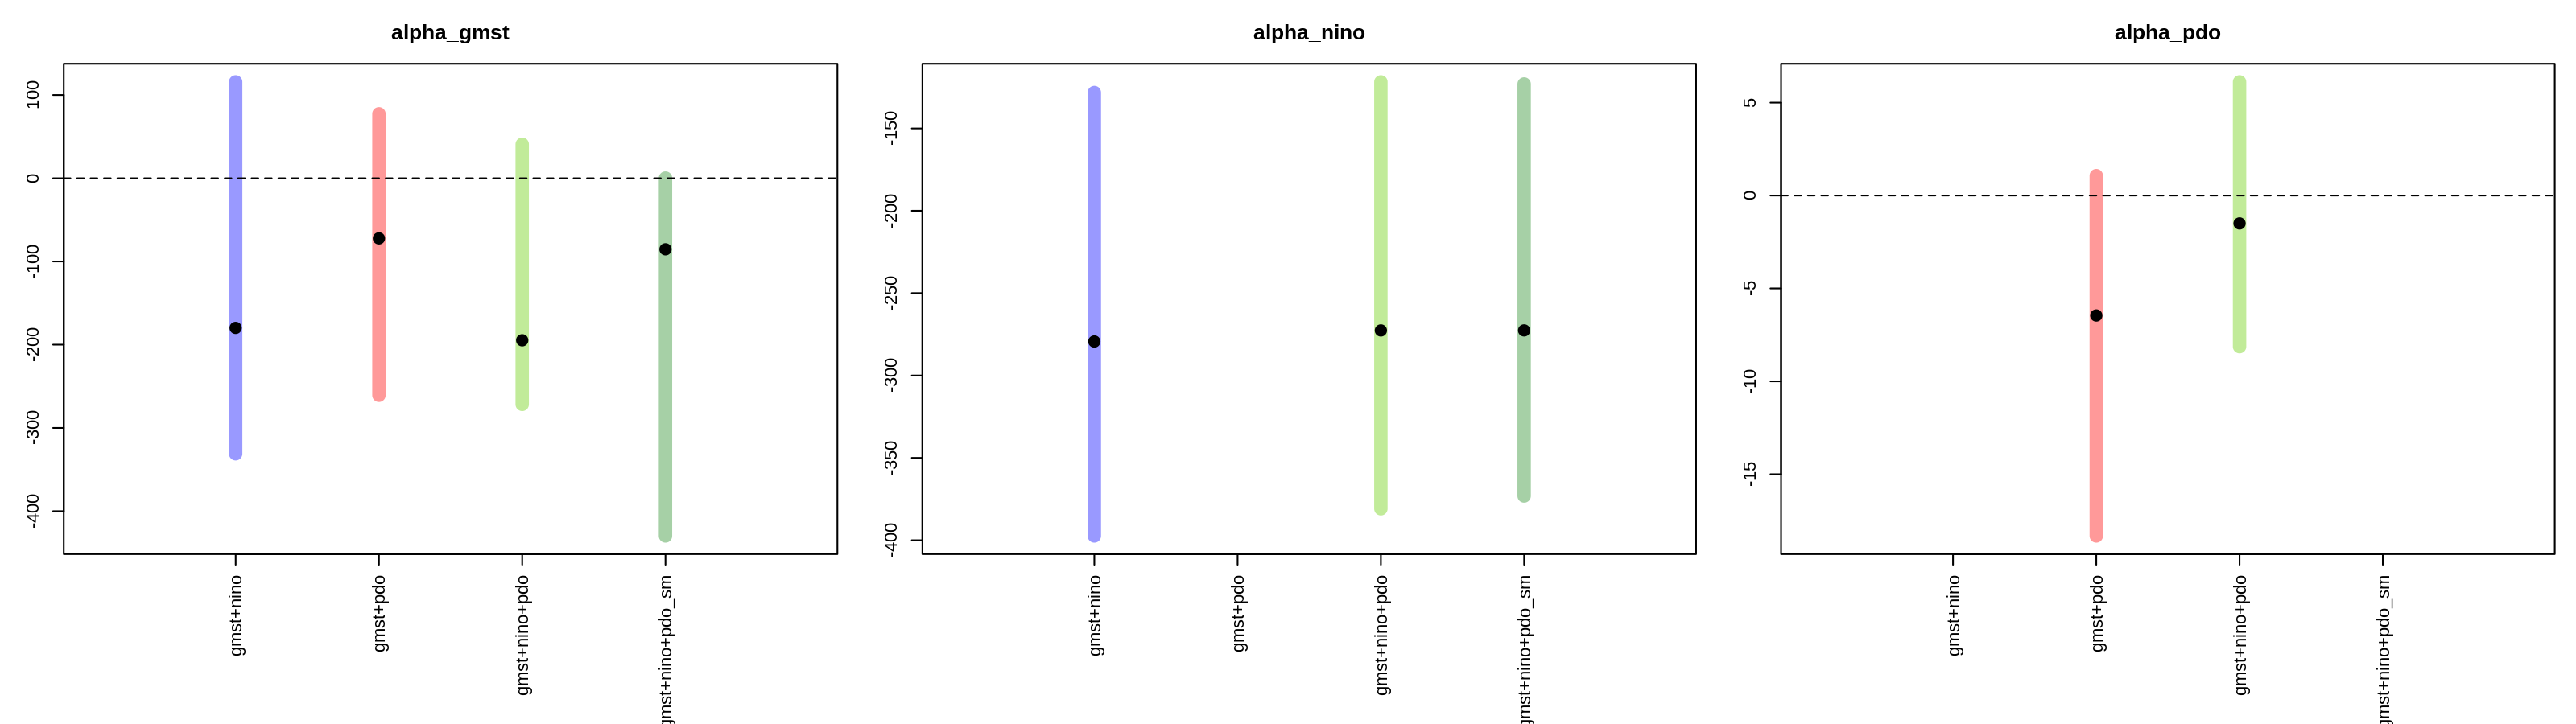

In [329]:
plot_pars <- c("alpha_gmst", "alpha_nino", "alpha_pdo")
n <- 4
prep_window(c(1,4), h = 4.5); par(mar = c(8,3,3,1))

    par(mfrow = c(1,length(plot_pars)))

    for (r in plot_pars) {
        res <- t(sapply(all_res, function(res) if(r %in% rownames(res)) {res[r,]} else {setNames(rep(NA,3), colnames(all_res[[1]]))}))
        ylim = range(res, na.rm = T)
        
        plot(1, type = "n", ylim = ylim, xlim = c(0,n+1), main = r, xaxt = "n", xlab = "", ylab = "", log = "")
        axis(1, at = 1:n, labels = names(all_res), las = 2)
        segments(x0 = 1:n, y0 = res[,"2.5%"], y1 = res[,"97.5%"], lwd = 8, col = adjustcolor(c("blue", "red", "chartreuse3", "forestgreen"), alpha = 0.4))
        points(1:n, res[,"est"], pch = 20, cex = 2)
        abline(h = 0, lty = 2)
    }

### Or the AMO?

_Also no. Will look in more detail at some point_

In [370]:
amo <- read.table("data/amo_ersst.txt", comment = "#", row.names = "V1")
amo[amo < -100] <- NA
amo <- data.frame(year = rownames(amo), amo = rowMeans(amo, na.rm = T))

In [371]:
# load & compile data
nino <- load_ts("ts/panama_nino-rs.dat", col.names = c("year", "nino"))
gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2023]

df <- merge(merge(merge(gmst, nino), load_ts("ts/panama_pr-wetseason_acp-sat.dat", col.names = c("year", "pr"))), amo)

cov_2023 <- df[df$year == 2023,c("gmst", "nino", "amo")]
cov_cf <- rbind("hist" = cov_2023 - c(1.2,0,0), "neut" = cov_2023 - c(0,cov_2023$nino,0))

In [374]:
models <- list("gmst+nino" = fit_ns("norm", "fixeddisp", df, "pr", c("gmst", "nino"), lower = T),
               "gmst+amo" = fit_ns("norm", "fixeddisp", df, "pr", c("gmst", "amo"), lower = T),
               "gmst+nino+amo" = fit_ns("norm", "fixeddisp", df, "pr", c("gmst", "nino", "amo"), lower = T))

In [375]:
# no evidence that fit is improved
round(sapply(models, aic), 2)

gmst+nino      gmst+amo gmst+nino+amo 
       635.30        652.39        637.06

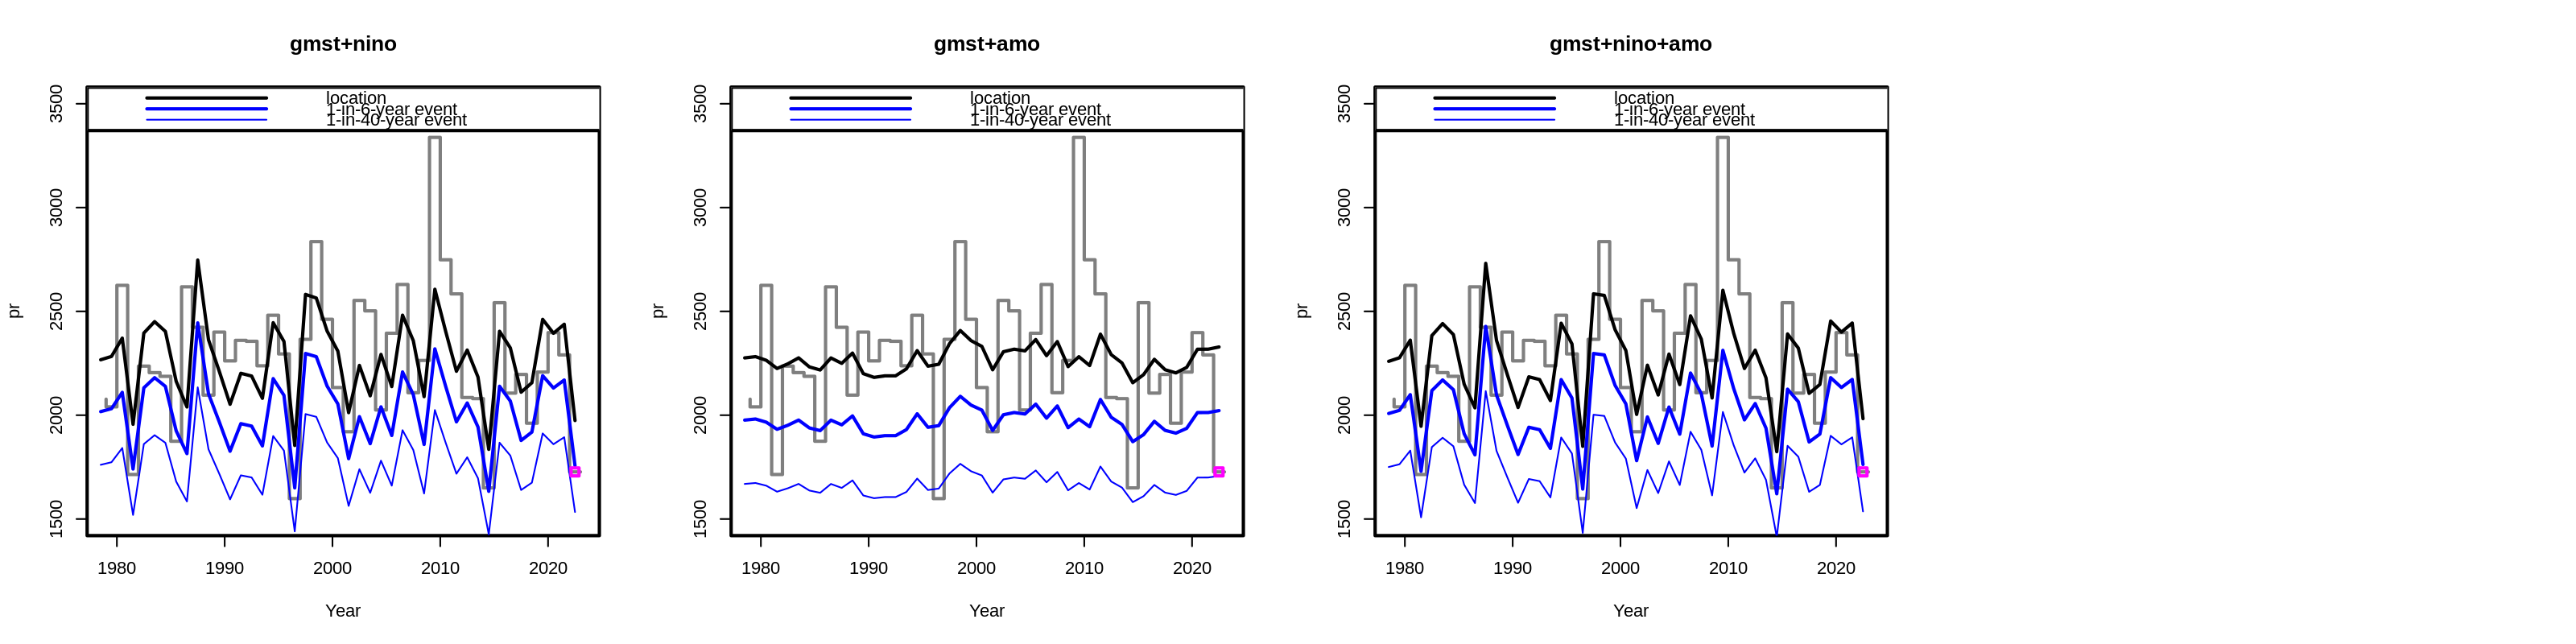

In [376]:
prep_window(c(1,4), h = 4, w = 4, lwd = 2)

for (i in 1:length(models)) {
    mdl <- models[[i]]
    plot_trend(mdl, main = names(models)[i])
}

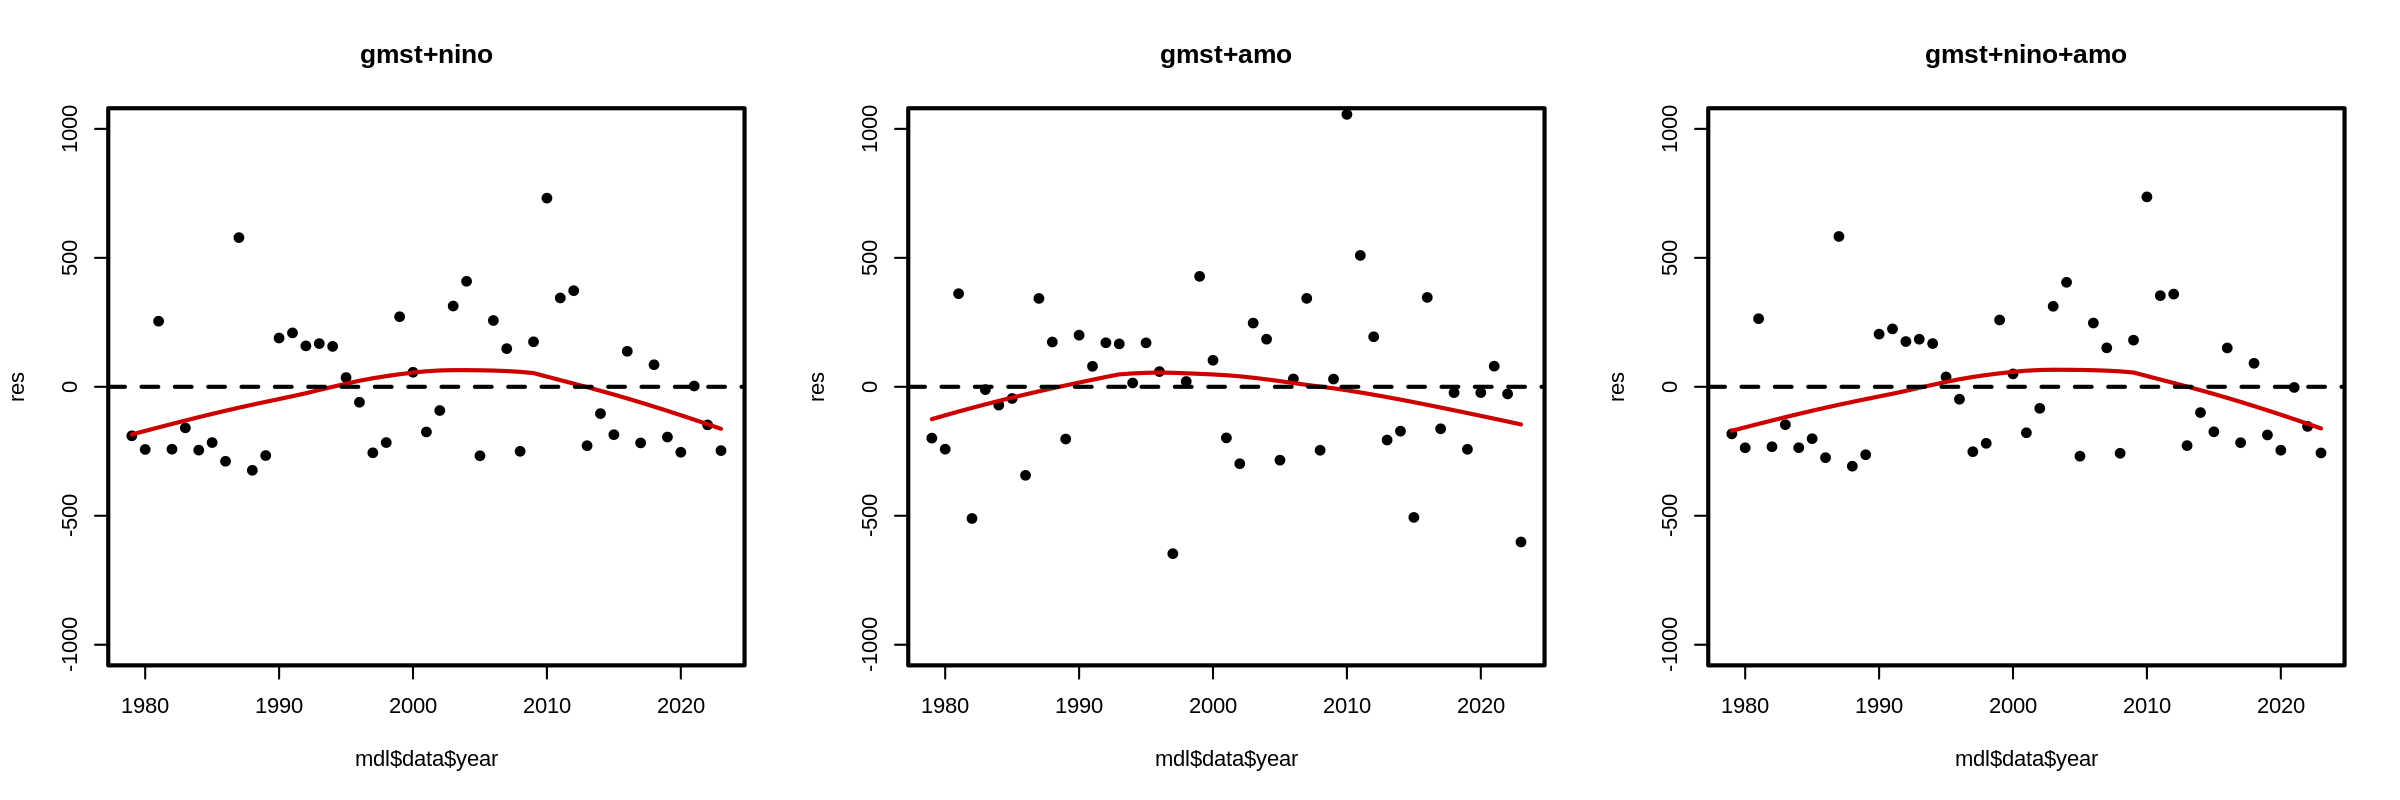

In [377]:
prep_window(c(1,length(models)), h = 4, w = 4, lwd = 2)

for (i in 1:length(models)) {
    mdl <- models[[i]]
    res <- mdl$x - ns_pars(mdl)$loc
    plot(mdl$data$year, res, main = names(models)[i], ylim = c(-1000,1000))
    lines(lowess(mdl$data$year, res), col = "red3")
    abline(h = 0, lty = 2)
}

## Return level plots

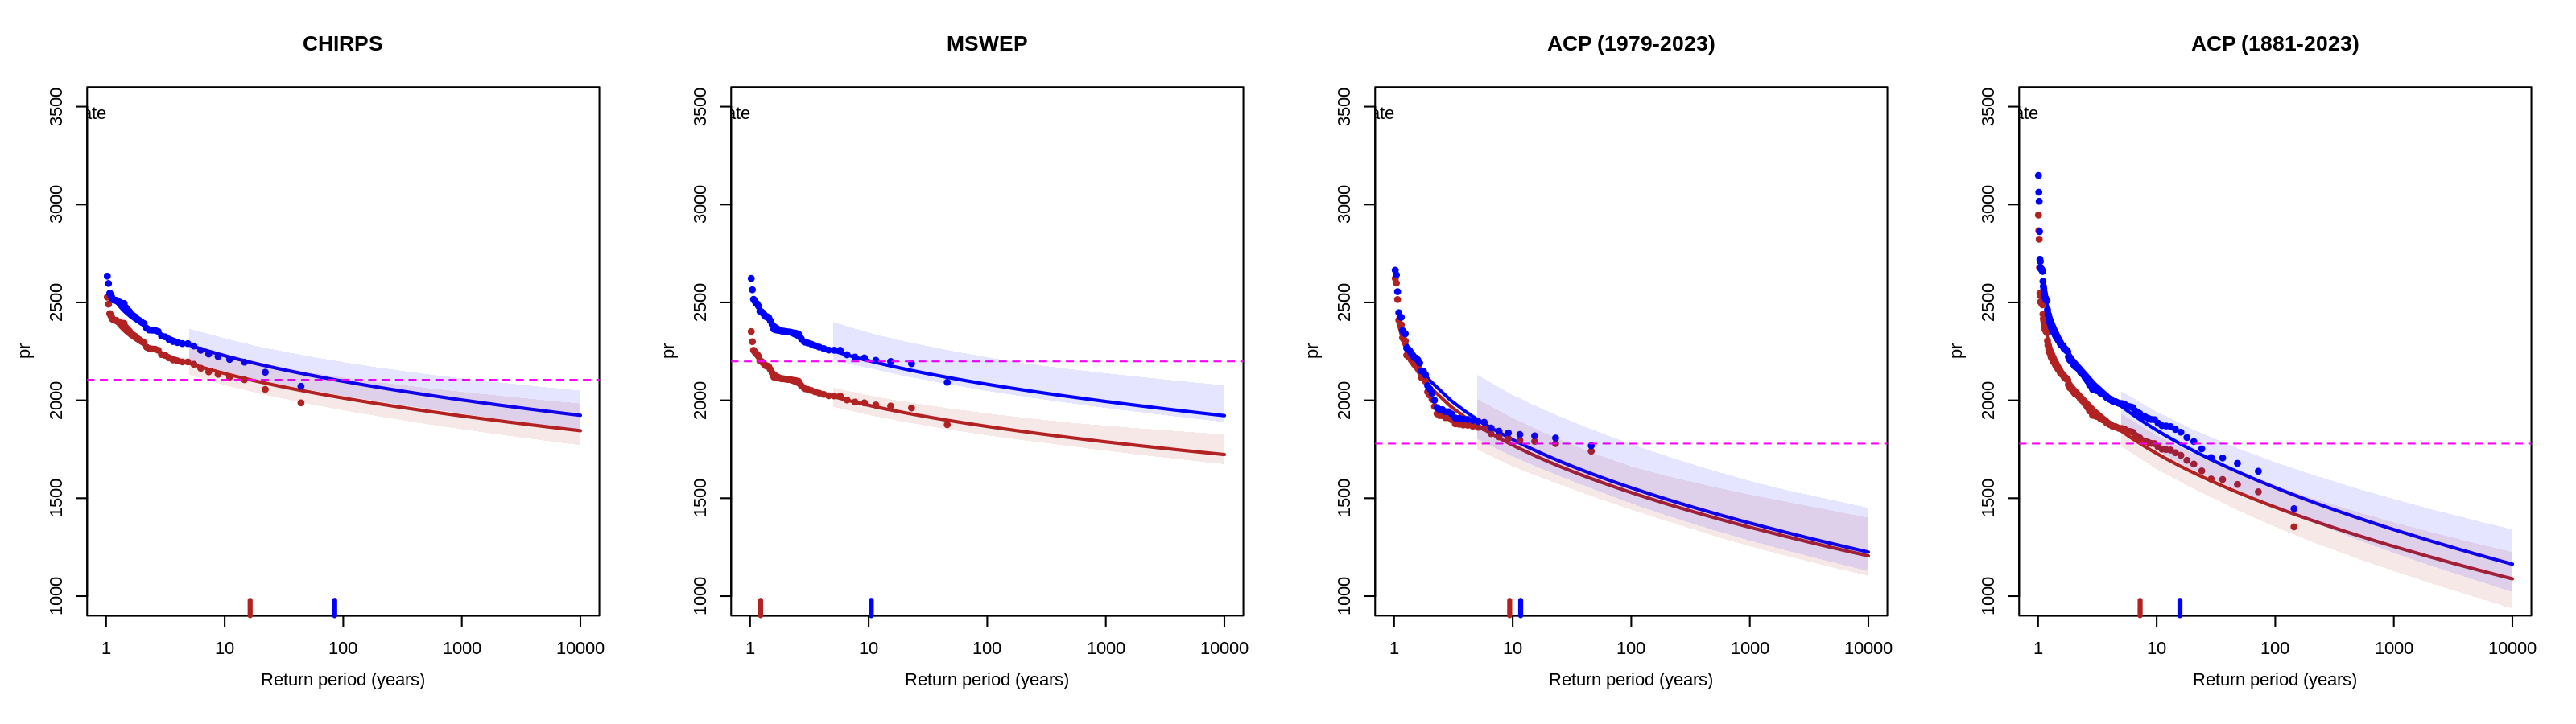

In [45]:
prep_window(c(1,4), h = 4.5)
ns = 50
ylim <- c(1000,3500) 
plot_returnlevels(chirps_nino, cov_f = cov_2023, cov_cf = cov_cf["hist",,drop=F], main = "CHIRPS", nsamp = ns, ylim = ylim)
plot_returnlevels(mswep_nino, cov_f = cov_2023, cov_cf = cov_cf["hist",,drop=F], main = "MSWEP", nsamp = ns, ylim = ylim)
plot_returnlevels(acp_nino_sat, cov_f = cov_2023, cov_cf = cov_cf["hist",,drop=F], main = "ACP (1979-2023)", nsamp = ns, ylim = ylim)
plot_returnlevels(acp_nino, cov_f = cov_2023, cov_cf = cov_cf["hist",,drop=F], main = "ACP (1881-2023)", nsamp = ns, ylim = ylim)

## Parameter estimates

In [37]:
# what do the model results look like?
res_chirps <- boot_ci(chirps_nino, cov_f = cov_2023, cov_cf = cov_cf)
res_acp <- boot_ci(acp_nino, cov_f = cov_2023, cov_cf = cov_cf)
res_acp_sat <- boot_ci(acp_nino_sat, cov_f = cov_2023, cov_cf = cov_cf)
res_mswep <- boot_ci(mswep_nino, cov_f = cov_2023, cov_cf = cov_cf)

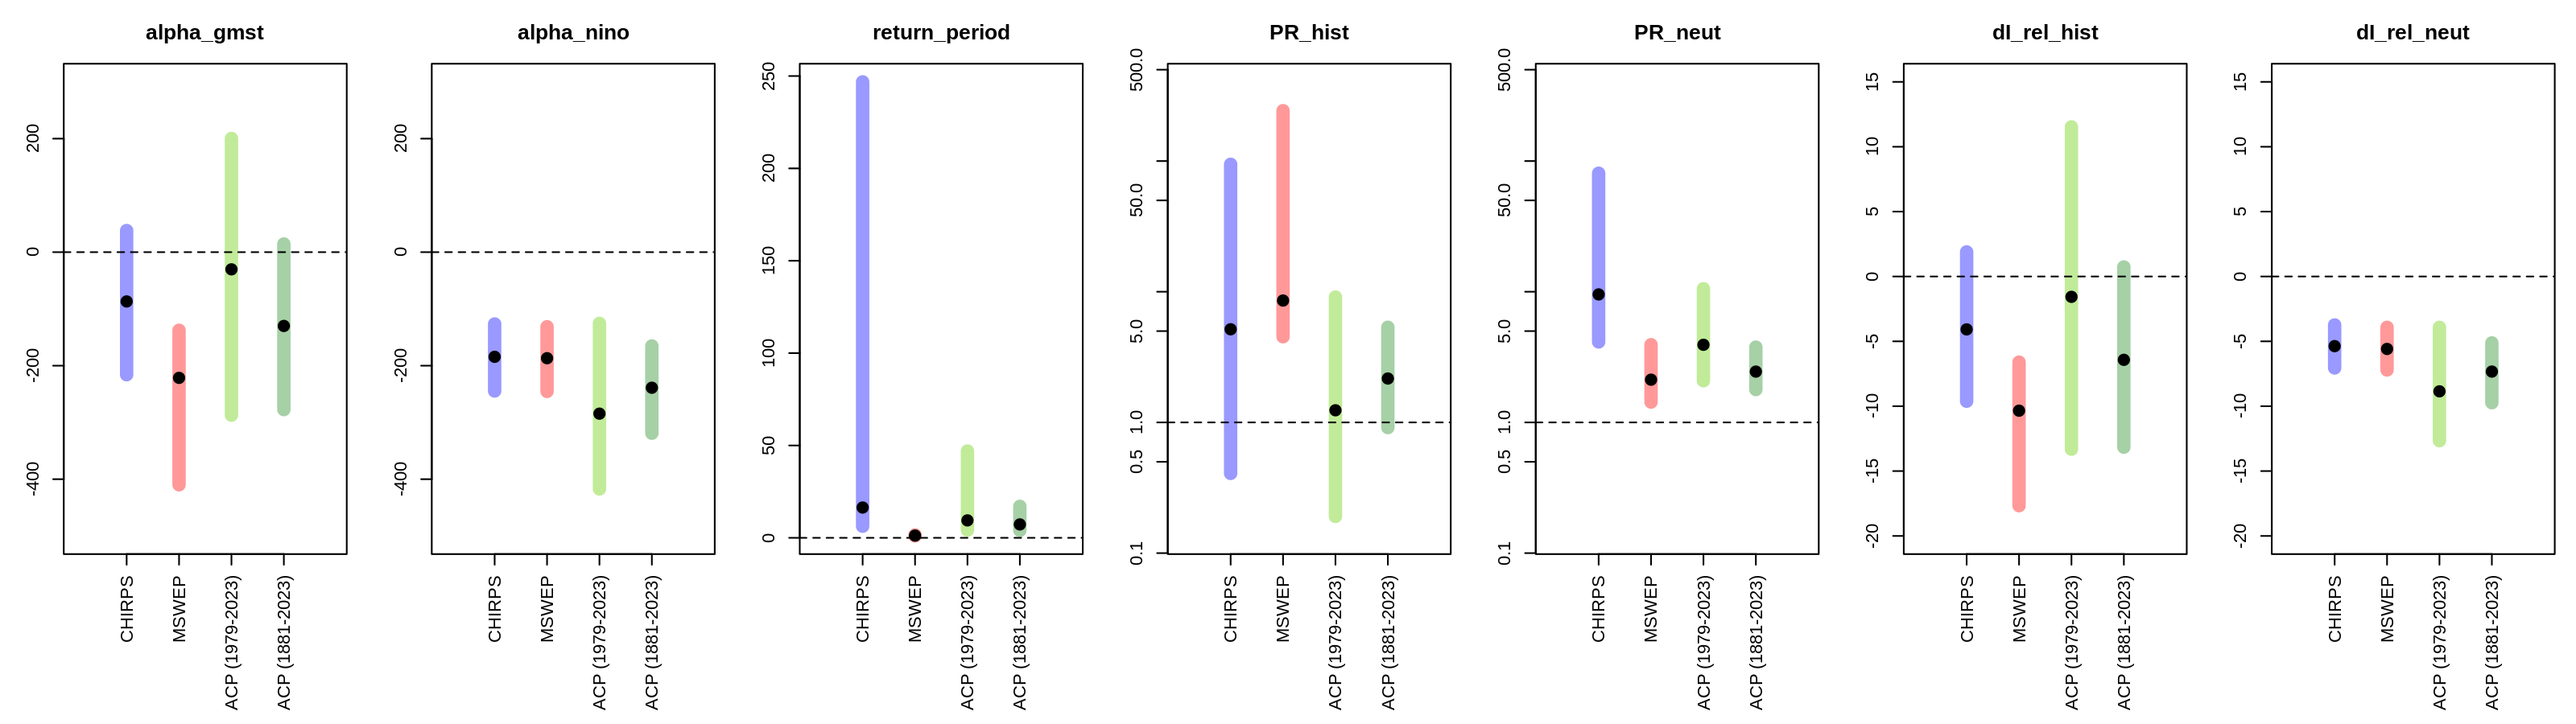

In [38]:
all_res <- abind::abind("CHIRPS" = res_chirps, "MSWEP" = res_mswep, "ACP (1979-2023)" = res_acp_sat, "ACP (1881-2023)" = res_acp, along = 0)

plot_pars <- c("alpha_gmst", "alpha_nino", "return_period", "PR_hist", "PR_neut", "dI_rel_hist", "dI_rel_neut")
prep_window(c(1,4), h = 4.5); par(mar = c(8,3,3,1))

    par(mfrow = c(1,length(plot_pars)))

    for (r in plot_pars) {
        res <- all_res[,r,]
        ylim = range(res, na.rm = T)
        
        n <- nrow(res)
        if(grepl("alpha", r)) {
            ylim = range(pretty(all_res[,grepl("alpha", colnames(all_res)),]))
        } 
        
        if(grepl("dI_rel", r)) {
            ylim = range(pretty(all_res[,grepl("dI_rel", colnames(all_res)),]))
        } 
        
        if(grepl("PR", r)) {
            h = 1
            logaxs = "y"
            ylim = exp(range(pretty(log(all_res[,grepl("PR", colnames(all_res)),]))))
        } else {
            h = 0
            logaxs = ""
        }
        
        plot(1, type = "n", ylim = ylim, xlim = c(0,n+1), main = r, xaxt = "n", xlab = "", ylab = "", log = logaxs)
        axis(1, at = 1:n, labels = rownames(res), las = 2)
        segments(x0 = 1:n, y0 = res[,"2.5%"], y1 = res[,"97.5%"], lwd = 8, col = adjustcolor(c("blue", "red", "chartreuse3", "forestgreen"), alpha = 0.4))
        points(1:n, res[,"est"], pch = 20, cex = 2)
        abline(h = h, lty = 2)
    }

# Model for gridded data

In [3]:
nino <- load_ts("ts/panama_nino-rs.dat", col.names = c("year", "nino"))
gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2023]

df <- read.csv("data/chirps_pr-MJJASOND_flattened.csv", skip = 3, header = F)
colnames(df)[1] <- "year"

df <- merge(merge(nino, gmst), df)

cov_2023 <- data.frame(gmst = gmst$gmst[gmst$year == 2023], nino = nino$nino[nino$year == 2023])
cov_cf <- rbind("hist" = cov_2023 - c(1.2, 0), "neut" = c(cov_2023$gmst, 0))

In [5]:
# fit nonstationary model to all grid cells
models <- sapply(colnames(df)[-(1:3)], function(cnm) {
    df_c <- df[,c("year", "gmst", "nino", cnm)]
    fit_ns("norm", "fixeddisp", df_c, cnm, c("gmst", "nino"), lower = T)
}, simplify = F)

In [6]:
fitted_res <- sapply(models, mdl_ests, cov_f = cov_2023, cov_cf = cov_cf)
fitted_res <- rbind(fitted_res, rp_neut = sapply(models, function(mdl) return_period(mdl, x = mdl$ev, fixed_cov = cov_cf["neut",,drop=F])))
write.csv(fitted_res, "res/res_rs_chirps-gridded.csv")

# Imputation of missing months in station data
Using predictive mean matching based on year & month, as this guarantees realistic values

In [3]:
library(mice)


Attaching package: ‘mice’


The following object is masked from ‘package:stats’:

    filter


The following objects are masked from ‘package:base’:

    cbind, rbind




## Test imputation method

In [16]:
# load all station data
df <- read.csv("data/pr_stations_acp_monthly.csv", row.names = "X")

df <- cbind("year" = as.integer(substr(rownames(df),1,4), "month" = as.integer(substr(rownames(df),6,7), df)

imputed <- df

for(stn in colnames(df)[2:(ncol(df)-2)][1:3]) {
    
    # select the station, year & month columns
    z <- df[,c("year", "month", stn)]
    
    # trim any data prior to first partially complete year; get indices
    years_available <- which(z$year >= min(z$year[!is.na(z[,stn])]))
    z <- z[years_available,]
    
    imputed[years_available, stn] <- complete(mice(z, method = "pmm", print = F))[,stn]
}

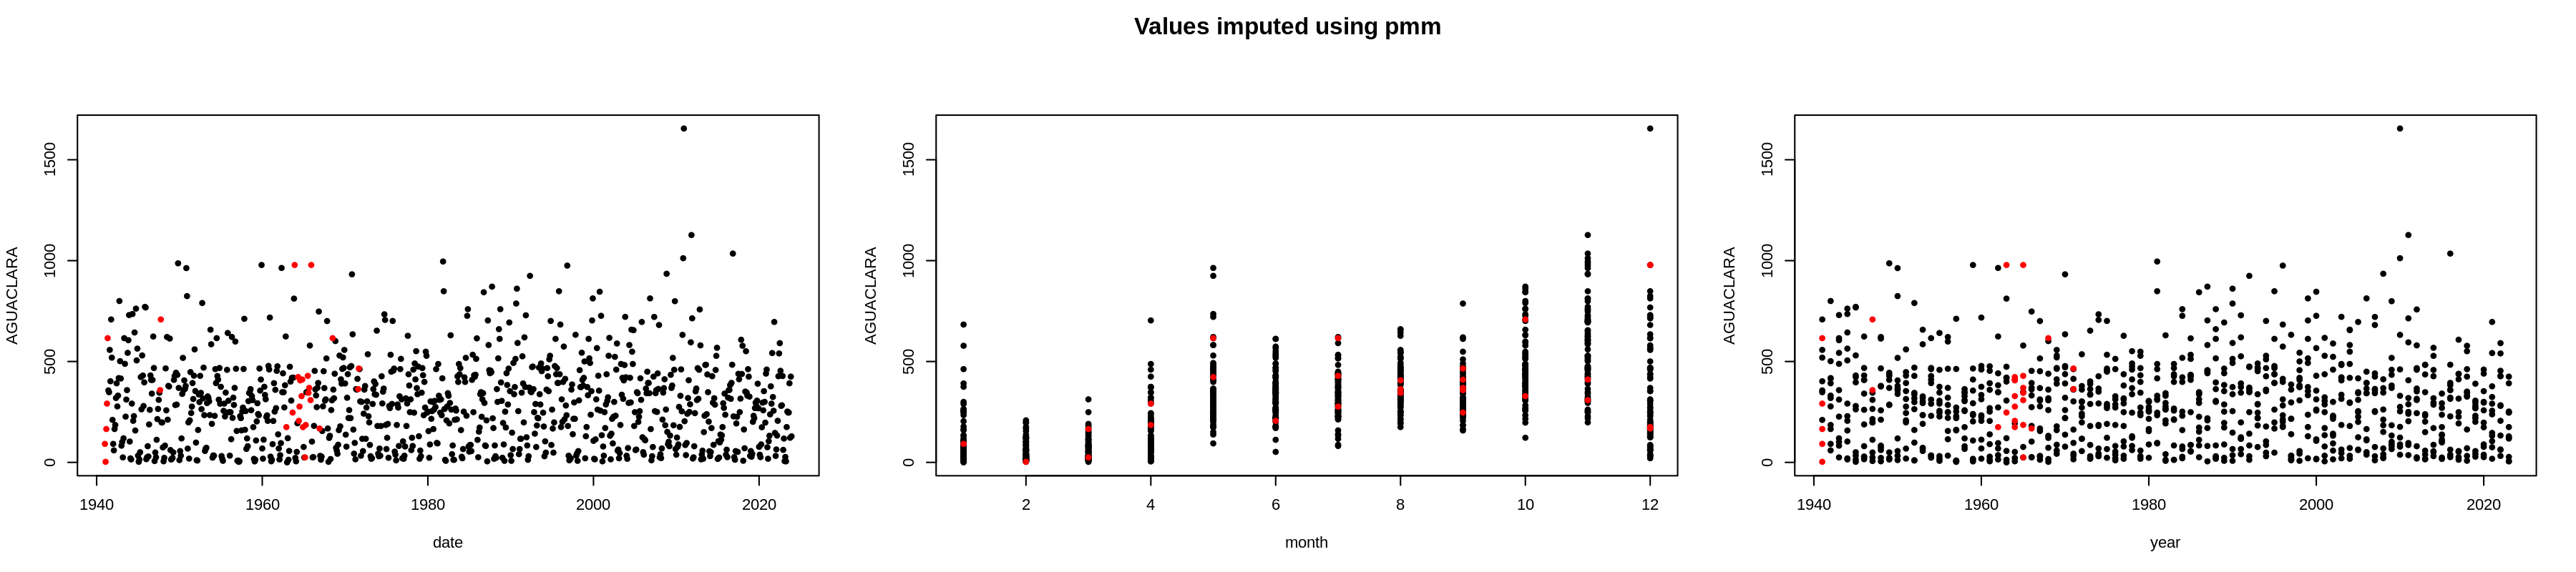

In [21]:
stn <- "AGUACLARA"; mthd <- "pmm"

z <- df[,c("year", "month", stn)]
z <- z[z$year >= min(z$year[!is.na(z[,stn])]),]

set.seed(42)
z_imp <- complete(mice(z, method = mthd, print = F))
colnames(z_imp)[3] <- mthd
z <- merge(z, z_imp)

z$date <- z$year+((z$month-1)/12)

prep_window(c(1,3), w = 6, oma = c(0,0,2,0))

for(xvar in c("date", "month", "year")) {
    plot(z[,c(xvar, stn)])
    points(z[is.na(z[,stn]), c(xvar, mthd)], col = "red")
}

mtext(paste0("Values imputed using ", mthd), outer = T, font = 2, line = 0)

## Impute data for subset of stations

_If time, would be useful to resample the imputation and test the effect on the fitted model_

In [129]:
# set period to select & minimum number of partial years required
start_year <- 1925; min_months <- 0; min_years <- 95

# load all station data, add year & month
df <- read.csv("data/pr_stations_acp_monthly.csv", row.names = "X")
df <- cbind("year" = as.integer(substr(rownames(df),1,4)),
            "month" = as.integer(substr(rownames(df),6,7)), df)

# trim to required period
df <- df[df$year >= start_year,]

# count months each year with non-missing data
nmonths = aggregate(!is.na(df)[,-(1:2)], list(df$year), FUN = "sum")[,-1]

# select only stations with min_years 
df <- df[,c("year", "month", colnames(nmonths)[colSums(nmonths > min_months) > min_years])]

# could also consider removing any stations with more than a certain number of missing months in total? But think this is fine for now

In [132]:
# store imputed values in a new dataframe
imputed <- df
set.seed(42)
for(stn in colnames(df)[-(1:2)]) {
     
    imputed[,stn] <- complete(mice(df[,c("year", "month", stn)], method = "pmm", print = F))[,stn]
}
imputed <- imputed[,-(1:2)]    # trim off year & month, no longer needed
write.csv(imputed, paste0("data/pr-imputed_stations_acp-", start_year, ".csv"))

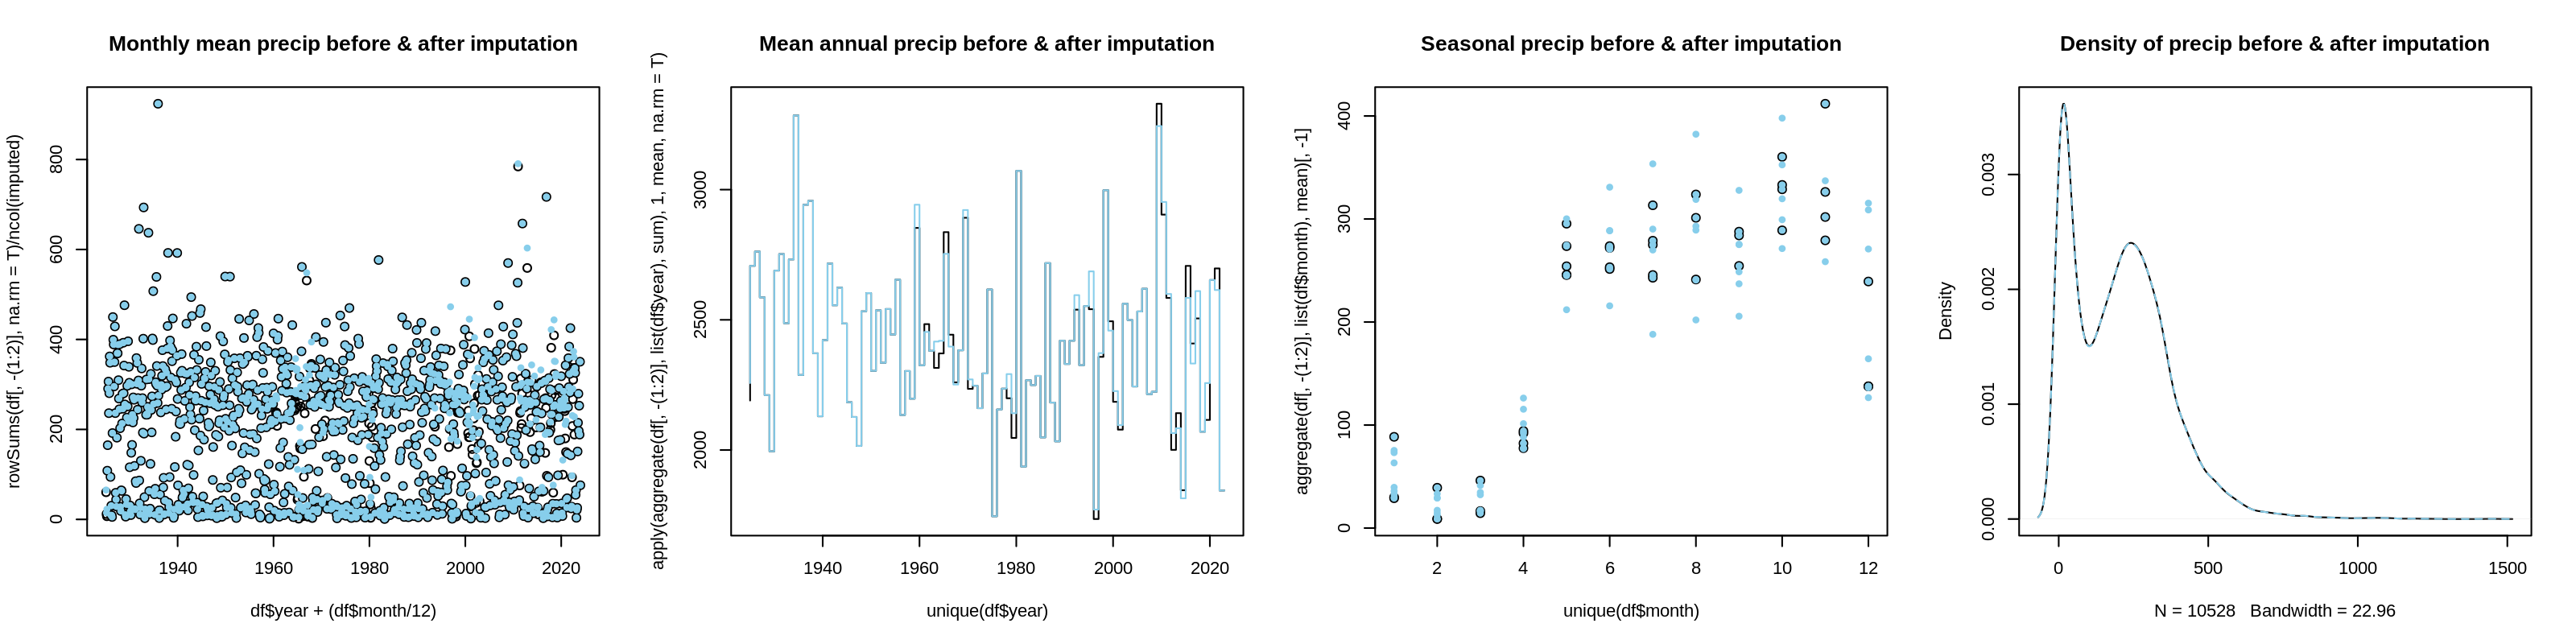

In [133]:
prep_window(c(1,4))

plot(df$year+(df$month/12), rowSums(df[,-(1:2)], na.rm = T) / ncol(imputed), pch = 1, main = "Monthly mean precip before & after imputation")
points(df$year+(df$month/12), rowSums(imputed) / ncol(imputed), pch = 20, col = "skyblue")

plot(unique(df$year), apply(aggregate(df[,-(1:2)], list(df$year), sum), 1, mean, na.rm = T), type = "S", main = "Mean annual precip before & after imputation")
lines(unique(df$year), apply(aggregate(imputed, list(df$year), sum), 1, mean, na.rm = T), type = "S", col = "skyblue")

# matplot(unique(df$year), aggregate(df[,-(1:2)], list(df$year), sum)[,-1], pch = 1, col = "black", main = "Annual total precip before & after imputation")
# matplot(unique(df$year), aggregate(imputed, list(df$year), sum)[,-1], pch = 20, col = "skyblue", add = T)

matplot(unique(df$month), aggregate(df[,-(1:2)], list(df$month), mean)[,-1], pch = 1, col = "black", main = "Seasonal precip before & after imputation")
matplot(unique(df$month), aggregate(imputed, list(df$month), mean)[,-1], pch = 20, col = "skyblue", add = T)

plot(density(unlist(df[,-(1:2)]), na.rm = T), main = "Density of precip before & after imputation")
lines(density(unlist(imputed)), col = "skyblue", lty = 2)

## Fit models at each station

In [170]:
ys <- "1925"

df <- read.csv(paste0("data/pr-imputed_stations_acp-",ys,".csv"), row.names = "X")
df <- cbind("year" = as.integer(substr(rownames(df),1,4)),
            "month" = as.integer(substr(rownames(df),6,7)), df)

# select rainy season month & sum annual precip
df <- aggregate(df[df$month > 4,-(1:2)], list("year" = df[df$month > 4,"year"]), sum)

# add covariates
nino <- load_ts("ts/panama_nino-rs.dat", col.names = c("year", "nino"))
gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
df <- merge(merge(gmst, nino), df)

cov_2023 <- data.frame(gmst = gmst$gmst[gmst$year == 2023], nino = nino$nino[nino$year == 2023])
cov_cf <- rbind("hist" = cov_2023 - c(1.2, 0), "neut" = c(cov_2023$gmst, 0))

In [171]:
# fit nonstationary model to all stations
models <- sapply(colnames(df)[-(1:3)], function(stn) {
    df_stn <- df[,c("year", "gmst", "nino", stn)]
    fit_ns("norm", "fixeddisp", df_stn, stn, c("gmst", "nino"), lower = T)
}, simplify = F)

In [172]:
# get standard output and save as .csv
fitted_res <- sapply(models, mdl_ests, cov_f = cov_2023, cov_cf = cov_cf)
fitted_res <- rbind(fitted_res, rp_neut = sapply(models, function(mdl) return_period(mdl, x = mdl$ev, fixed_cov = cov_cf["neut",,drop=F])))
write.csv(fitted_res, paste0("res/res_rs_stations-",ys,"-imputed.csv"))